---

# 2. Multi-Year Optimization (20 Years)

## Setup and Parameters

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
# Cost for increasing line capacities
# -----------------------
# 10-year settings
# ------------------------
years = range(1, 11)  # Years 1..10

#randomly generated growth factors for each year
load_growth_factor = {
    1: 0.9,
    2: 1.05,
    3: 1.02,
    4: 1.08,
    5: 0.95,
    6: 1.1,
    7: 0.97,
    8: 1.03,
    9: 1.06,
    10: 0.92
}


In [7]:

#Input data we are making a electricity system with 3 generators and 3 demands and 8 buses in total
#they should not be slack buses
buses = {
    'Bus1': {'type': 'generator'},
    'Bus2': {'type': 'generator'},
    'Bus3': {'type': 'generator'},
    'Bus4': {'type': 'generator'},
    'Bus5': {'type': 'load'},
    'Bus6': {'type': 'generator'},
    'Bus7': {'type': 'load'},
    'Bus8': {'type': 'load'},
}
generators = {
    'Gen1': {'bus': 'Bus1', 'capacity': 300, 'cost': 20},
    'Gen2': {'bus': 'Bus2', 'capacity': 150, 'cost': 10},
    'Gen3': {'bus': 'Bus3', 'capacity': 600, 'cost': 30},
    'Gen4': {'bus': 'Bus4', 'capacity': 0, 'cost': 0},
    'Gen5': {'bus': 'Bus6', 'capacity': 0, 'cost': 0},
}
loads = {
    'Load5': {'bus': 'Bus5', 'demand': 80},
    'Load7': {'bus': 'Bus7', 'demand': 120},
    'Load8': {'bus': 'Bus8', 'demand': 150},
}
lines = {
    ('Bus1', 'Bus4'): {'capacity': 50},
    ('Bus1', 'Bus2'): {'capacity': 50},
    ('Bus2', 'Bus3'): {'capacity': 70},
    ('Bus2', 'Bus5'): {'capacity': 50},
    ('Bus3', 'Bus6'): {'capacity': 90},
    ('Bus4', 'Bus7'): {'capacity': 80},
    ('Bus5', 'Bus7'): {'capacity': 70},    
    ('Bus5', 'Bus6'): {'capacity': 65},
    ('Bus6', 'Bus8'): {'capacity': 50},  
    ('Bus7', 'Bus8'): {'capacity': 30},
}  
#Cost for increasing line capacities
line_upgrade_cost = 5  # Cost per unit increase in line capacity 



Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 290 rows, 280 columns and 1680 nonzeros
Model fingerprint: 0x1a46b4fd
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [5e+00, 1e+02]
  Bounds range     [2e+02, 6e+02]
  RHS range        [3e+01, 5e+02]
Presolve removed 71 rows and 90 columns
Presolve time: 0.01s
Presolved: 219 rows, 190 columns, 1966 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      84    6.4120000e+04   0.000000e+00   0.000000e+00      0s

Solved in 84 iterations and 0.03 seconds (0.00 work units)
Optimal objective  6.412000000e+04

Total 20-year cost: 64120.00

Yearly line upgrades:

Year 1:
  Upgrade on line Bus1 - Bus4: 30.00 MW
  Up

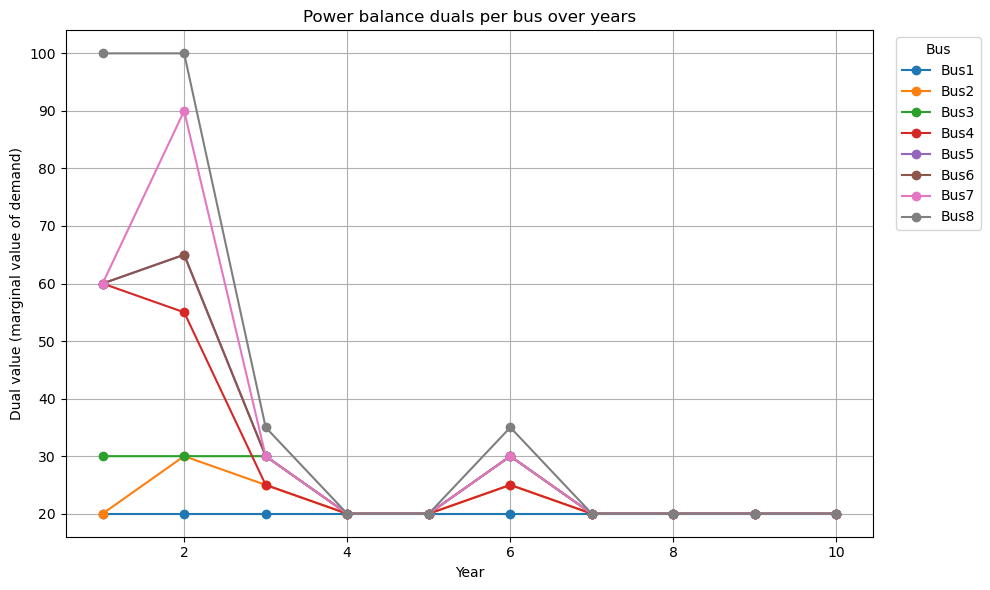

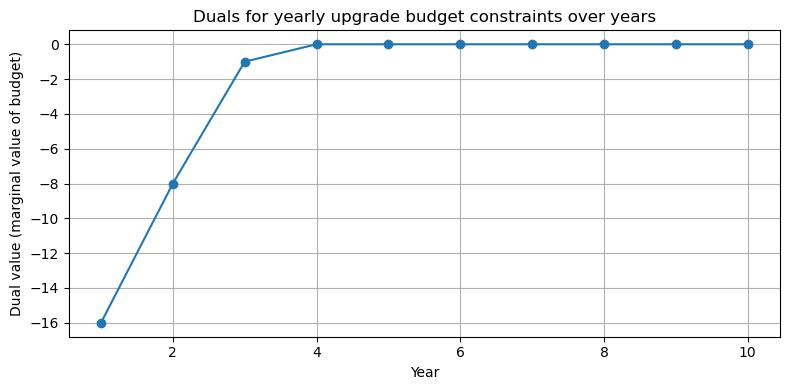

In [8]:

line_upgrade_cost = 5  # Cost per unit increase in line capacity

yearly_upgrade_budget = 500  # total money per year for all line upgrades

# Value of Lost Load (penalty for shedding)
VOLL = 100  # €/MW or similar

# ------------------------
# Model
# ------------------------
model = gp.Model("electricity_system_20_years_with_budget")

# Generator outputs per year
gen_vars = {}
for gen, data in generators.items():
    for y in years:
        gen_vars[(gen, y)] = model.addVar(
            lb=0,
            ub=data['capacity'],
            name=f"GenOutput_{gen}_Y{y}"
        )

# Line flows per year (signed: + from bus_from to bus_to)
line_vars = {}
for (bus_from, bus_to), data in lines.items():
    for y in years:
        line_vars[(bus_from, bus_to, y)] = model.addVar(
            lb=-GRB.INFINITY,
            name=f"LineFlow_{bus_from}_{bus_to}_Y{y}"
        )

# Line capacity upgrades per line and year (incremental, cumulative over time)
line_upgrade_vars = {}
for (bus_from, bus_to), data in lines.items():
    for y in years:
        line_upgrade_vars[(bus_from, bus_to, y)] = model.addVar(
            lb=0,
            name=f"LineUpgrade_{bus_from}_{bus_to}_Y{y}"
        )

# Load shedding per load and year (unserved demand)
shed_vars = {}
for load, load_data in loads.items():
    for y in years:
        shed_vars[(load, y)] = model.addVar(
            lb=0,
            name=f"Shed_{load}_Y{y}"
        )

model.update()

# ------------------------
# Line capacity constraints
# For each year: |flow_y| <= base_capacity + sum(upgrades up to year y)
# ------------------------
for (bus_from, bus_to), data in lines.items():
    base_cap = data['capacity']
    for y in years:
        f = line_vars[(bus_from, bus_to, y)]
        # cumulative upgrade up to and including year y
        upgraded_cap = base_cap + gp.quicksum(
            line_upgrade_vars[(bus_from, bus_to, yy)]
            for yy in years if yy <= y
        )
        model.addConstr(
            f <= upgraded_cap,
            name=f"CapPos_{bus_from}_{bus_to}_Y{y}"
        )
        model.addConstr(
            f >= -upgraded_cap,
            name=f"CapNeg_{bus_from}_{bus_to}_Y{y}"
        )

# ------------------------
# Yearly budget constraints for upgrades
# sum_lines (upgrade_cost * upgrade_var[line,y]) <= yearly_upgrade_budget
# ------------------------
for y in years:
    model.addConstr(
        gp.quicksum(
            line_upgrade_cost * line_upgrade_vars[(bus_from, bus_to, y)]
            for (bus_from, bus_to) in lines.keys()
        ) <= yearly_upgrade_budget,
        name=f"UpgradeBudget_Y{y}"
    )

# ------------------------
# Power balance at each bus and year
# generation + net_import + shed = demand
# ------------------------
for y in years:
    for bus, bus_data in buses.items():
        generation = gp.LinExpr()
        net_import = gp.LinExpr()
        demand = gp.LinExpr()
        shed = gp.LinExpr()

        # Generation at this bus in year y
        for gen, gen_data in generators.items():
            if gen_data['bus'] == bus:
                generation += gen_vars[(gen, y)]

        # Net import from incident lines
        for (bus_from, bus_to), _ in lines.items():
            f = line_vars[(bus_from, bus_to, y)]
            if bus == bus_from:
                net_import += -f   # export if f > 0
            elif bus == bus_to:
                net_import += f    # import if f > 0

        # Demand and shedding at this bus in year y
        for load, load_data in loads.items():
            if load_data['bus'] == bus:
                base_demand = load_data['demand']
                demand += base_demand * load_growth_factor[y]
                shed += shed_vars[(load, y)]

        # Power balance
        model.addConstr(
            generation + net_import + shed == demand,
            name=f"PowerBalance_{bus}_Y{y}"
        )

# ------------------------
# Objective: generation cost + upgrade cost + shedding penalty
# ------------------------
gen_cost = gp.quicksum(
    gen_vars[(gen, y)] * generators[gen]['cost']
    for gen in generators
    for y in years
)

upgrade_cost_total = gp.quicksum(
    line_upgrade_cost * line_upgrade_vars[(bus_from, bus_to, y)]
    for (bus_from, bus_to) in lines.keys()
    for y in years
)

shed_cost = gp.quicksum(
    shed_vars[(load, y)] * VOLL
    for load in loads
    for y in years
)

model.setObjective(gen_cost + upgrade_cost_total + shed_cost, GRB.MINIMIZE)

# ------------------------
# Optimize
# ------------------------
model.optimize()

# ------------------------
# Results
# ------------------------
if model.status == GRB.OPTIMAL:
    print(f"\nTotal 20-year cost: {model.objVal:.2f}")

    print("\nYearly line upgrades:")
    for y in years:
        any_up = False
        for (bus_from, bus_to) in lines.keys():
            up = line_upgrade_vars[(bus_from, bus_to, y)].X
            if up > 1e-6:
                if not any_up:
                    print(f"\nYear {y}:")
                    any_up = True
                print(f"  Upgrade on line {bus_from} - {bus_to}: {up:.2f} MW")

    print("\nYearly effective line capacities (cumulative):")
    for y in years:
        print(f"\nYear {y}:")
        for (bus_from, bus_to), data in lines.items():
            base_cap = data['capacity']
            cum_upgrade = sum(
                line_upgrade_vars[(bus_from, bus_to, yy)].X
                for yy in years if yy <= y
            )
            eff_cap = base_cap + cum_upgrade
            print(f"  {bus_from} -> {bus_to}: {eff_cap:.2f} MW  (base {base_cap}, cum. upgrade {cum_upgrade:.2f})")

    print("\nYearly generation (non-zero):")
    for y in years:
        print(f"\nYear {y}:")
        for gen in generators.keys():
            val = gen_vars[(gen, y)].X
            if abs(val) > 1e-6:
                print(f"  {gen}: {val:.2f} MW")

    print("\nYearly load shedding (if any):")
    for y in years:
        any_shed = False
        for load in loads.keys():
            s = shed_vars[(load, y)].X
            if s > 1e-6:
                if not any_shed:
                    print(f"\nYear {y}:")
                    any_shed = True
                print(f"  Shed at {load}: {s:.2f} MW")
    
    # Print duals (shadow prices) for power balance constraints
    print("\nDuals for power balance constraints (marginal value of demand at each bus/year):")
    for y in years:
        for bus in buses.keys():
            cname = f"PowerBalance_{bus}_Y{y}"
            constr = model.getConstrByName(cname)
            if constr is not None:
                print(f"{cname}: {constr.Pi:.6f}")
            else:
                print(f"{cname}: constraint not found")

    #Print the shadow prices for line capacity constraints
    # Shadow prices for line capacity constraints
    print("\nShadow prices for line capacity constraints (CapPos / CapNeg):")
    for y in years:
        print(f"\nYear {y}:")
        for (bus_from, bus_to) in lines.keys():
            cpos = model.getConstrByName(f"CapPos_{bus_from}_{bus_to}_Y{y}")
            cneg = model.getConstrByName(f"CapNeg_{bus_from}_{bus_to}_Y{y}")
            pi_pos = cpos.Pi if cpos is not None else float('nan')
            pi_neg = cneg.Pi if cneg is not None else float('nan')
            print(f"  {bus_from}->{bus_to}: CapPos={pi_pos:.6f}, CapNeg={pi_neg:.6f}")

    print("\nDual variables for yearly upgrade budget constraints:")
    for y in years:
        cname = f"UpgradeBudget_Y{y}"
        constr = model.getConstrByName(cname)
        if constr is not None:
            print(f"{cname}: {constr.Pi:.6f}")
        else:
            print(f"{cname}: constraint not found")

else:
    print("Model not optimal. Status code:", model.status)


# Plot duals (shadow prices) of the power balance constraints for each bus over years
duals = {bus: [] for bus in buses.keys()}

for y in years:
    for bus in buses.keys():
        cname = f"PowerBalance_{bus}_Y{y}"
        constr = model.getConstrByName(cname)
        if constr is not None and model.status == GRB.OPTIMAL:
            duals[bus].append(constr.Pi)
        else:
            duals[bus].append(float('nan'))

fig, ax = plt.subplots(figsize=(10, 6))
x = list(years)
for bus, vals in duals.items():
    ax.plot(x, vals, marker='o', label=bus)

ax.set_xlabel('Year')
ax.set_ylabel('Dual value (marginal value of demand)')
ax.set_title('Power balance duals per bus over years')
ax.grid(True)
ax.legend(title='Bus', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# collect duals for yearly upgrade budget constraints
budget_duals = []
for y in years:
    constr = model.getConstrByName(f"UpgradeBudget_Y{y}")
    if constr is not None and model.status == GRB.OPTIMAL:
        budget_duals.append(constr.Pi)
    else:
        budget_duals.append(float('nan'))

# plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(years), budget_duals, marker='o', linestyle='-')
ax.set_xlabel('Year')
ax.set_ylabel('Dual value (marginal value of budget)')
ax.set_title('Duals for yearly upgrade budget constraints over years')
ax.grid(True)
plt.tight_layout()
plt.show()


## Model Formulation and Solution

---

## Visualizations: Multi-Year Results

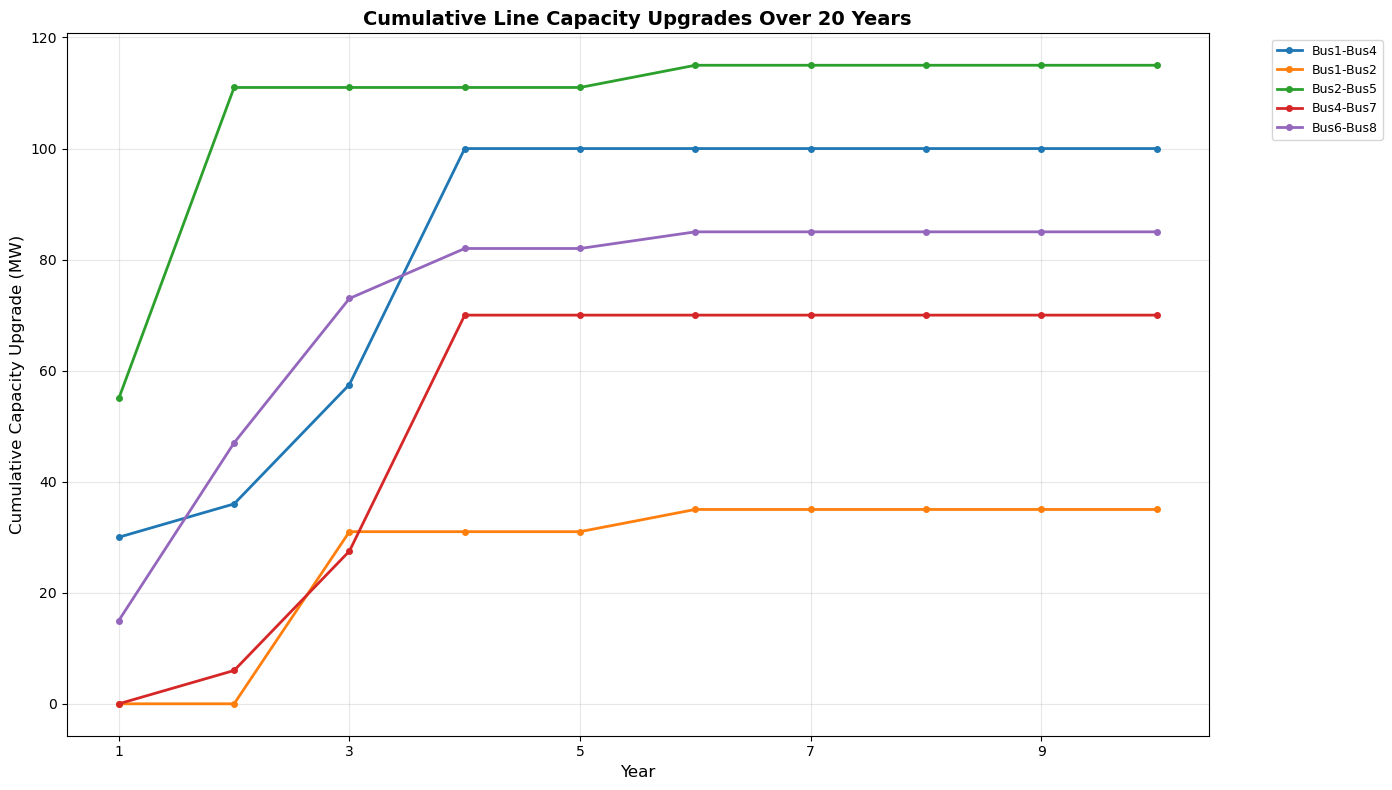

In [9]:
# 1. Cumulative Line Capacity Upgrades Over Time
fig, ax = plt.subplots(figsize=(14, 8))

for (bus_from, bus_to) in lines.keys():
    cumulative_upgrades = []
    for y in years:
        cum = sum(line_upgrade_vars[(bus_from, bus_to, yy)].X for yy in years if yy <= y)
        cumulative_upgrades.append(cum)
    
    # Only plot lines that have upgrades
    if max(cumulative_upgrades) > 0.1:
        ax.plot(list(years), cumulative_upgrades, marker='o', 
               label=f'{bus_from}-{bus_to}', linewidth=2, markersize=4)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Capacity Upgrade (MW)', fontsize=12)
ax.set_title('Cumulative Line Capacity Upgrades Over 20 Years', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 11, 2))

plt.tight_layout()
plt.show()

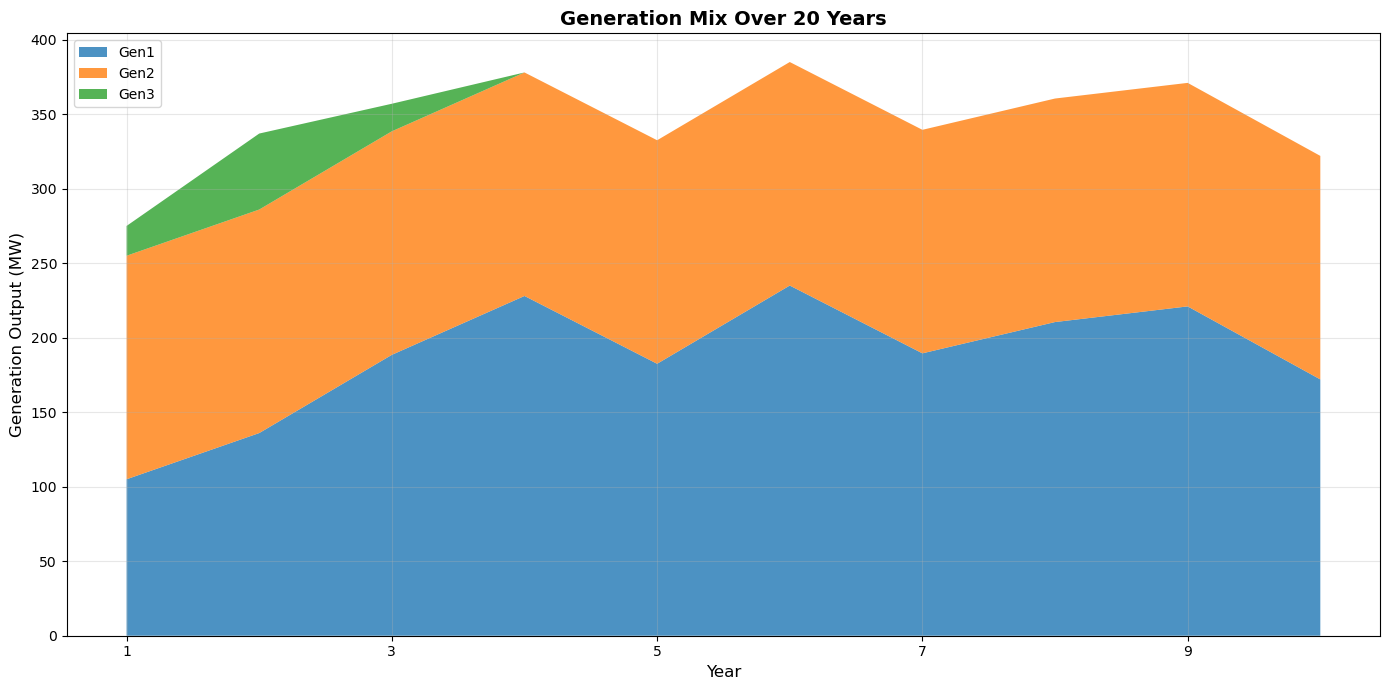

In [10]:
# 2. Generation Mix Over Time (Stacked Area Chart)
fig, ax = plt.subplots(figsize=(14, 7))

# Filter to only show generators with capacity > 0
active_gens = [gen for gen in generators.keys() if generators[gen]['capacity'] > 0]

# Prepare data for stacked area chart
gen_data = {gen: [] for gen in active_gens}
for y in years:
    for gen in active_gens:
        gen_data[gen].append(gen_vars[(gen, y)].X)

# Create stacked area chart
ax.stackplot(list(years), *[gen_data[gen] for gen in active_gens],
            labels=active_gens, alpha=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Generation Output (MW)', fontsize=12)
ax.set_title('Generation Mix Over 20 Years', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 11, 2))

plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

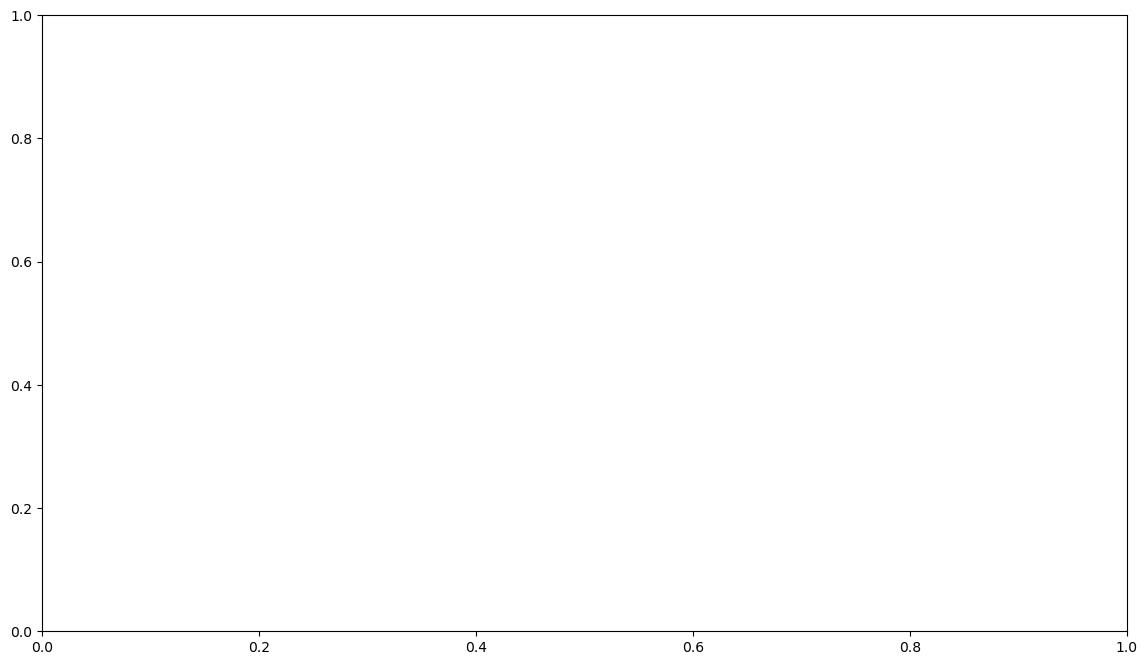

In [11]:
# 3. Line Utilization Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare utilization matrix
line_labels = [f"{bf}-{bt}" for (bf, bt) in lines.keys()]
utilization_matrix = np.zeros((len(lines), len(years)))

for i, (bus_from, bus_to) in enumerate(lines.keys()):
    base_cap = lines[(bus_from, bus_to)]['capacity']
    for j, y in enumerate(years):
        flow = abs(line_vars[(bus_from, bus_to, y)].X)
        cum_upgrade = sum(line_upgrade_vars[(bus_from, bus_to, yy)].X for yy in years if yy <= y)
        total_cap = base_cap + cum_upgrade
        utilization = (flow / total_cap * 100) if total_cap > 0 else 0
        utilization_matrix[i, j] = utilization

# Create heatmap
im = ax.imshow(utilization_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(np.arange(len(years)))
ax.set_yticks(np.arange(len(line_labels)))
ax.set_xticklabels(years)
ax.set_yticklabels(line_labels)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Transmission Line', fontsize=12)
ax.set_title('Line Utilization Over 20 Years (%)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Utilization (%)', fontsize=11)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

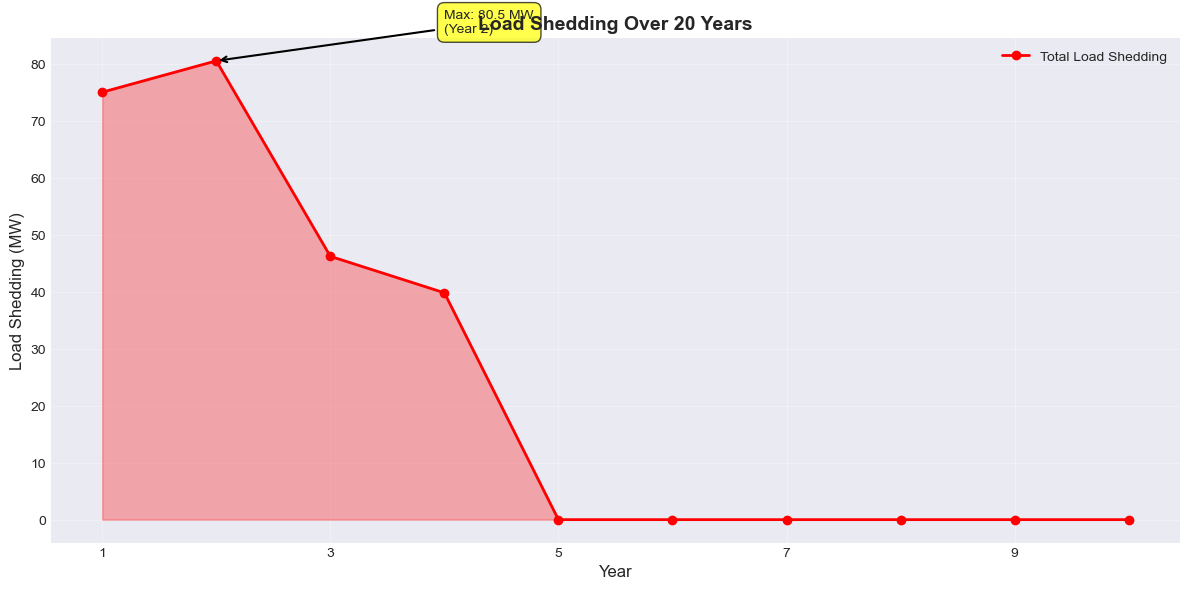

In [ ]:
# 4. Load Shedding Over Time
fig, ax = plt.subplots(figsize=(12, 6))

shed_by_year = []
for y in years:
    total_shed = sum(shed_vars[(load, y)].X for load in loads.keys())
    shed_by_year.append(total_shed)

ax.plot(list(years), shed_by_year, marker='o', linewidth=2, markersize=6, 
        color='red', label='Total Load Shedding')
ax.fill_between(list(years), shed_by_year, alpha=0.3, color='red')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Load Shedding (MW)', fontsize=12)
ax.set_title('Load Shedding Over 20 Years', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 11, 2))
ax.legend(fontsize=10)

# Add annotation if there's significant shedding
max_shed = max(shed_by_year)
if max_shed > 0.1:
    max_year = shed_by_year.index(max_shed) + 1
    ax.annotate(f'Max: {max_shed:.1f} MW\n(Year {max_year})',
               xy=(max_year, max_shed), xytext=(max_year+2, max_shed+5),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
               fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

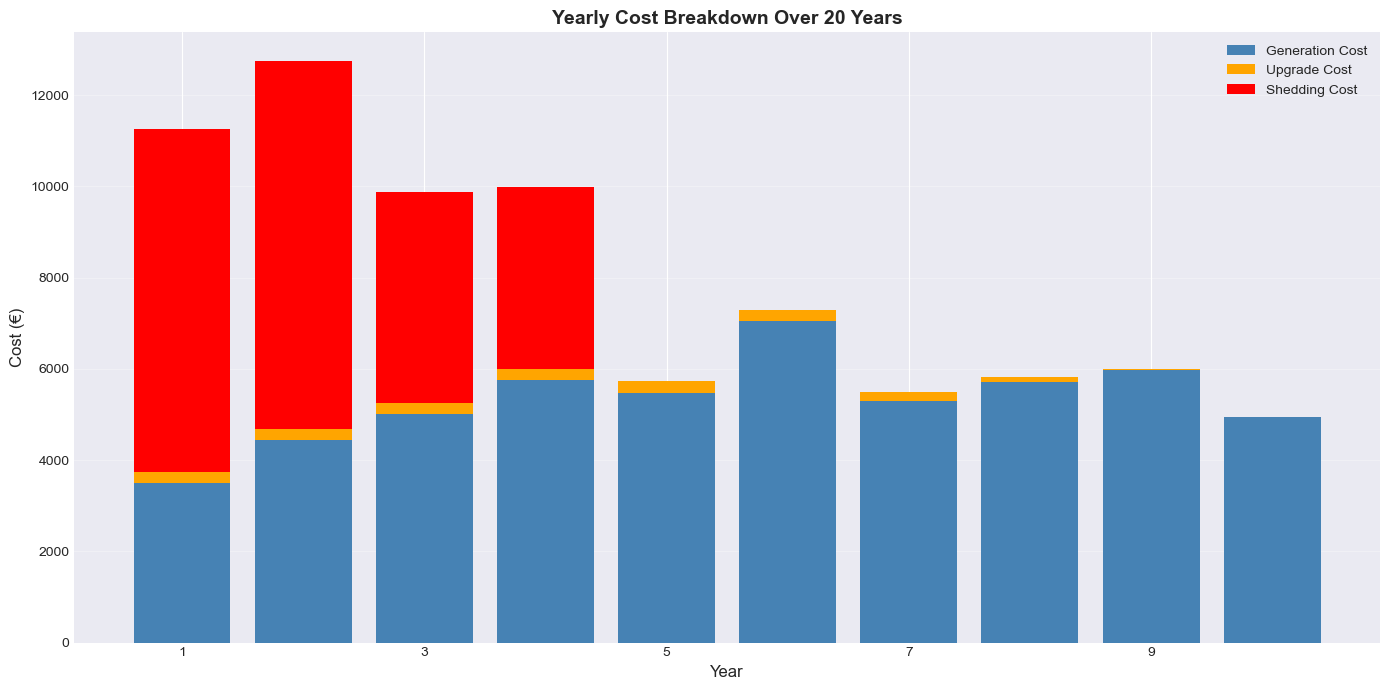

In [ ]:
# 5. Yearly Cost Breakdown (Stacked Bar Chart)
fig, ax = plt.subplots(figsize=(14, 7))

yearly_gen_cost = []
yearly_upgrade_cost = []
yearly_shed_cost = []

for y in years:
    gen_cost = sum(gen_vars[(gen, y)].X * generators[gen]['cost'] for gen in generators.keys())
    upgrade_cost = sum(line_upgrade_vars[(bf, bt, y)].X * line_upgrade_cost for (bf, bt) in lines.keys())
    shed_cost = sum(shed_vars[(load, y)].X * VOLL for load in loads.keys())
    
    yearly_gen_cost.append(gen_cost)
    yearly_upgrade_cost.append(upgrade_cost)
    yearly_shed_cost.append(shed_cost)

x = np.array(list(years))
width = 0.8

p1 = ax.bar(x, yearly_gen_cost, width, label='Generation Cost', color='steelblue')
p2 = ax.bar(x, yearly_upgrade_cost, width, bottom=yearly_gen_cost, 
           label='Upgrade Cost', color='orange')
p3 = ax.bar(x, yearly_shed_cost, width, 
           bottom=np.array(yearly_gen_cost) + np.array(yearly_upgrade_cost),
           label='Shedding Cost', color='red')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cost (€)', fontsize=12)
ax.set_title('Yearly Cost Breakdown Over 20 Years', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(1, 11, 2))

plt.tight_layout()
plt.show()

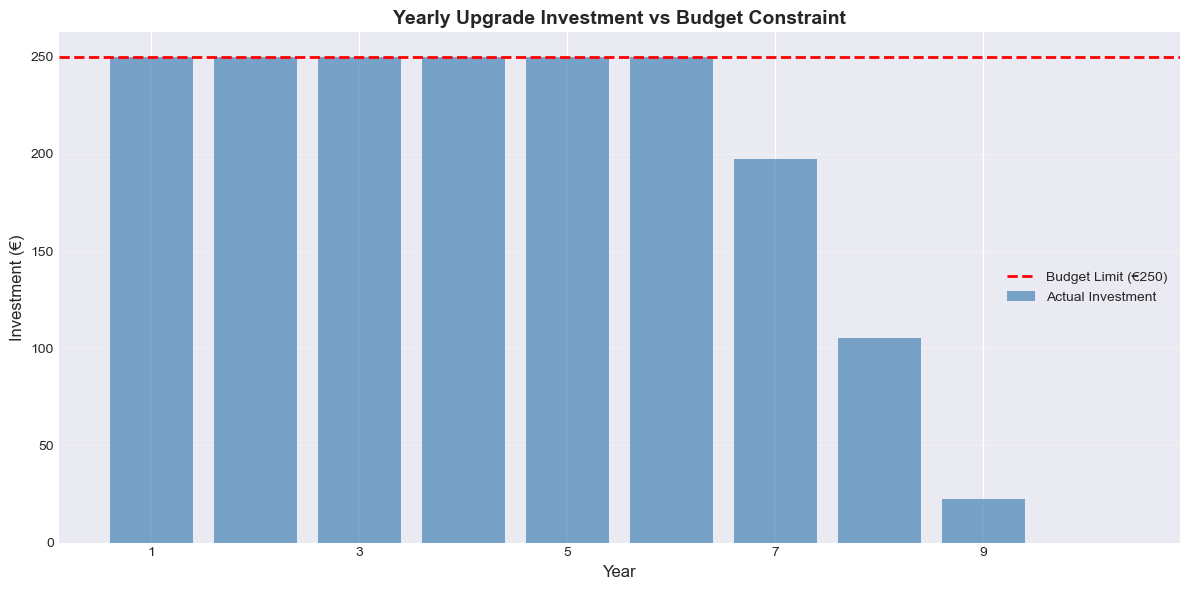

In [ ]:
# 6. Yearly Upgrade Investment vs Budget
fig, ax = plt.subplots(figsize=(12, 6))

yearly_investments = []
for y in years:
    investment = sum(line_upgrade_vars[(bf, bt, y)].X * line_upgrade_cost for (bf, bt) in lines.keys())
    yearly_investments.append(investment)

ax.bar(list(years), yearly_investments, color='steelblue', alpha=0.7, label='Actual Investment')
ax.axhline(y=yearly_upgrade_budget, color='red', linestyle='--', linewidth=2, label=f'Budget Limit (€{yearly_upgrade_budget})')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Investment (€)', fontsize=12)
ax.set_title('Yearly Upgrade Investment vs Budget Constraint', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(1, 11, 2))

plt.tight_layout()
plt.show()

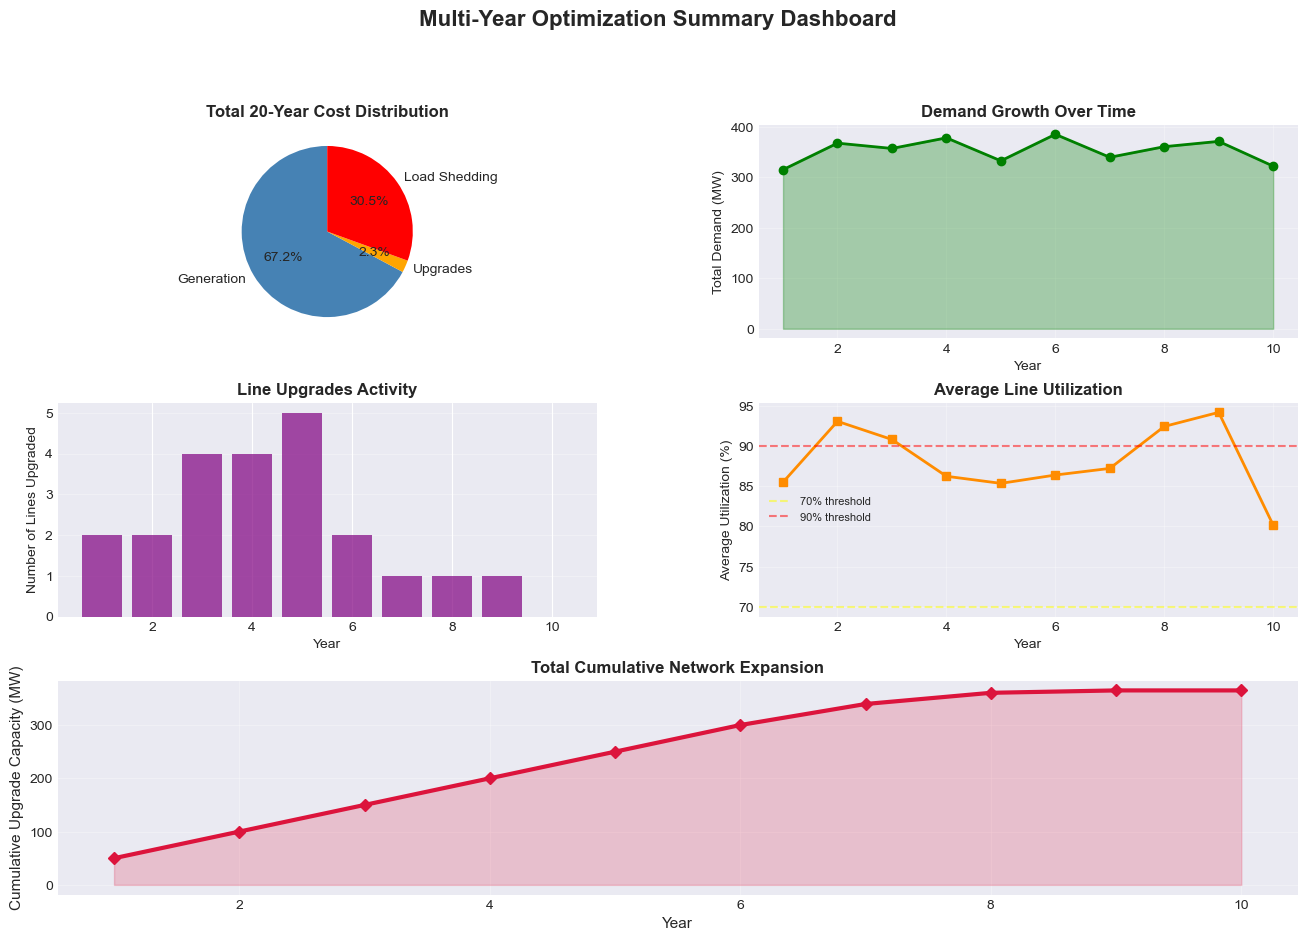

In [ ]:
# 7. Summary Dashboard - Multi-Year Overview
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Total costs by category
ax1 = fig.add_subplot(gs[0, 0])
total_gen = sum(yearly_gen_cost)
total_upgrade = sum(yearly_upgrade_cost)
total_shed = sum(yearly_shed_cost)
categories = ['Generation', 'Upgrades', 'Load Shedding']
values = [total_gen, total_upgrade, total_shed]
colors_pie = ['steelblue', 'orange', 'red']
ax1.pie(values, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax1.set_title('Total 20-Year Cost Distribution', fontweight='bold')

# Subplot 2: Demand growth over time
ax2 = fig.add_subplot(gs[0, 1])
total_demand_by_year = []
for y in years:
    total_demand = sum(loads[load]['demand'] * load_growth_factor[y] for load in loads.keys())
    total_demand_by_year.append(total_demand)
ax2.plot(list(years), total_demand_by_year, marker='o', color='green', linewidth=2)
ax2.fill_between(list(years), total_demand_by_year, alpha=0.3, color='green')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Demand (MW)')
ax2.set_title('Demand Growth Over Time', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Subplot 3: Number of line upgrades per year
ax3 = fig.add_subplot(gs[1, 0])
upgrades_per_year = []
for y in years:
    count = sum(1 for (bf, bt) in lines.keys() if line_upgrade_vars[(bf, bt, y)].X > 0.1)
    upgrades_per_year.append(count)
ax3.bar(list(years), upgrades_per_year, color='purple', alpha=0.7)
ax3.set_xlabel('Year')
ax3.set_ylabel('Number of Lines Upgraded')
ax3.set_title('Line Upgrades Activity', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Average line utilization per year
ax4 = fig.add_subplot(gs[1, 1])
avg_utilization_by_year = []
for y in years:
    utils = []
    for (bf, bt) in lines.keys():
        base_cap = lines[(bf, bt)]['capacity']
        flow = abs(line_vars[(bf, bt, y)].X)
        cum_upgrade = sum(line_upgrade_vars[(bf, bt, yy)].X for yy in years if yy <= y)
        total_cap = base_cap + cum_upgrade
        if total_cap > 0:
            utils.append(flow / total_cap * 100)
    avg_utilization_by_year.append(np.mean(utils) if utils else 0)

ax4.plot(list(years), avg_utilization_by_year, marker='s', color='darkorange', linewidth=2)
ax4.axhline(y=70, color='yellow', linestyle='--', alpha=0.5, label='70% threshold')
ax4.axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90% threshold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Average Utilization (%)')
ax4.set_title('Average Line Utilization', fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# Subplot 5: Cumulative upgrade capacity
ax5 = fig.add_subplot(gs[2, :])
cumulative_total_upgrades = []
for y in years:
    total = sum(sum(line_upgrade_vars[(bf, bt, yy)].X for yy in years if yy <= y) 
                for (bf, bt) in lines.keys())
    cumulative_total_upgrades.append(total)

ax5.plot(list(years), cumulative_total_upgrades, marker='D', color='crimson', 
         linewidth=3, markersize=6)
ax5.fill_between(list(years), cumulative_total_upgrades, alpha=0.2, color='crimson')
ax5.set_xlabel('Year', fontsize=11)
ax5.set_ylabel('Cumulative Upgrade Capacity (MW)', fontsize=11)
ax5.set_title('Total Cumulative Network Expansion', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

fig.suptitle('Multi-Year Optimization Summary Dashboard', fontsize=16, fontweight='bold', y=0.995)

plt.show()